In [12]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"  

import matplotlib
#matplotlib.use('Agg')  # No GUI calls

import matplotlib.pyplot as plt

In [13]:
import torch
from torch import nn
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [14]:
batch_size=32

In [15]:
import random
random.seed(42)

In [16]:
data_output = pd.read_csv("C:/Users/met48/Desktop/TS-Clustering/SimData/bank_reserves_outputs_poor.csv", header=None)
data_output_helper = data_output
new_row = [500] * data_output_helper.shape[1]
data_output_helper.loc[len(data_output_helper)] = new_row
scaler = MinMaxScaler()
scaler.fit(data_output_helper)
data_output_scaled = scaler.transform(data_output)
data_output = pd.DataFrame(data_output_scaled)

# --- Load the conditioning input parameters ---
data_input = pd.read_csv("C:/Users/met48/Desktop/TS-Clustering/SimData/bank_reserves_inputs.csv", sep=" ", header=None)

# --- Combine input + output ---
data = pd.concat([data_input, data_output], axis=1)

# --- Sample to 1280 examples if needed ---
data = data.sample(n=20000, random_state=1)

# --- Split into training and validation sets ---
train_data_pd, valid_data = train_test_split(data, test_size=0.2, random_state=42)

# --- Extract tensors for training ---
train_inputs = torch.tensor(train_data_pd.iloc[:, :1].values, dtype=torch.float32)
train_outputs = torch.tensor(train_data_pd.iloc[:, 1:].values, dtype=torch.float32)

valid_inputs = torch.tensor(valid_data.iloc[:, :1].values, dtype=torch.float32)
valid_outputs = torch.tensor(valid_data.iloc[:, 1:].values, dtype=torch.float32)

In [17]:
data

,0,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,100
3915,78.432312,0.0,0.0,0.0,0.002,0.004,0.010,0.012,0.018,0.024,...,0.054,0.062,0.058,0.058,0.064,0.062,0.064,0.062,0.062,0.058
28069,45.022241,0.0,0.0,0.0,0.002,0.006,0.012,0.024,0.036,0.038,...,0.236,0.232,0.236,0.242,0.248,0.234,0.236,0.236,0.226,0.232
80496,23.626896,0.0,0.0,0.0,0.000,0.002,0.006,0.012,0.016,0.018,...,0.292,0.290,0.300,0.296,0.296,0.306,0.306,0.304,0.320,0.316
51846,32.434221,0.0,0.0,0.0,0.002,0.004,0.010,0.022,0.032,0.044,...,0.288,0.292,0.296,0.298,0.308,0.310,0.316,0.318,0.318,0.312
55195,11.637353,0.0,0.0,0.0,0.000,0.000,0.006,0.010,0.020,0.036,...,0.264,0.266,0.262,0.262,0.274,0.274,0.288,0.282,0.284,0.284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28247,47.415942,0.0,0.0,0.0,0.002,0.008,0.006,0.008,0.020,0.026,...,0.224,0.242,0.232,0.228,0.232,0.230,0.236,0.238,0.226,0.230
25808,61.464472,0.0,0.0,0.0,0.000,0.002,0.010,0.020,0.026,0.044,...,0.140,0.140,0.140,0.142,0.144,0.142,0.138,0.136,0.144,0.142
3529,75.743780,0.0,0.0,0.0,0.002,0.008,0.010,0.012,0.016,0.022,...,0.074,0.068,0.072,0.076,0.080,0.082,0.074,0.070,0.070,0.072
35199,58.235536,0.0,0.0,0.0,0.002,0.004,0.010,0.014,0.018,0.030,...,0.158,0.156,0.156,0.158,0.148,0.148,0.154,0.156,0.160,0.160


In [18]:
train_inputs.shape[0]

16000

In [19]:
torch.manual_seed(1)

In [20]:
train_data_length = train_inputs.shape[0]
train_data = torch.from_numpy(train_data_pd.values).float().to('cpu')
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
train_data.shape

torch.Size([16000, 102])

In [21]:
from torch.utils.data import Dataset

class ConditionalTimeSeriesDataset(Dataset):
    def __init__(self, time_series_data, condition_data):
        """
        time_series_data: Tensor of shape (N, 252)
        condition_data: Tensor of shape (N, 3)
        """
        self.time_series_data = time_series_data
        self.condition_data = condition_data

    def __len__(self):
        return len(self.time_series_data)

    def __getitem__(self, idx):
        return self.time_series_data[idx], self.condition_data[idx]

In [22]:
from torch.utils.data import DataLoader

train_dataset = ConditionalTimeSeriesDataset(train_outputs, train_inputs)
valid_dataset = ConditionalTimeSeriesDataset(valid_outputs, valid_inputs)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

In [23]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_dim=101, condition_dim=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x, conditions):
        # Concatenate time series and condition
        x = torch.cat([x, conditions], dim=1)
        return self.model(x)

In [24]:
discriminator = ConditionalDiscriminator()

In [25]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, condition_dim=1, output_dim=101):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
        self.temporal_smoother = nn.Conv1d(1, 1, kernel_size=5, padding=2)  # keeps shape

    def forward(self, z, conditions):
        x = torch.cat([z, conditions], dim=1)
        out = self.fc(x)
        out = out.unsqueeze(1)  # (B, 1, 252)
        out = self.temporal_smoother(out)
        return out.squeeze(1)

generator = ConditionalGenerator()

In [26]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [27]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [28]:
losses_discriminator = []
losses_generator = []
steps = []

for epoch in range(num_epochs):
    for n, (real_samples, condition_vectors) in enumerate(train_loader):
        # real_samples: (batch_size, 252)
        # condition_vectors: (batch_size, 3)

        real_samples_labels = torch.ones((batch_size, 1))
        generated_samples_labels = torch.zeros((batch_size, 1))

        # Sample latent space
        latent_dim = 100
        latent_space_samples = torch.randn((batch_size, latent_dim))  # Latent space dimension

        # Ensure condition_vectors has the same batch size as latent_space_samples
        condition_vectors = condition_vectors.expand(batch_size, -1)  # Repeat condition vectors to match batch size

        # === Generator step ===
        # Pass latent_space_samples and condition_vectors separately to the generator
        generated_samples = generator(latent_space_samples, condition_vectors)

        # === Prepare discriminator input ===
        all_samples = torch.cat((real_samples, generated_samples.detach()), dim=0)
        all_conditions = torch.cat((condition_vectors, condition_vectors), dim=0)  # Duplicate for both real and generated
        all_labels = torch.cat((real_samples_labels, generated_samples_labels), dim=0)

        # === Train discriminator ===
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples, all_conditions)
        loss_discriminator = loss_function(output_discriminator, all_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # === Train generator ===
        generator.zero_grad()
        # Generate again to avoid using detached samples
        generated_samples = generator(latent_space_samples, condition_vectors)
        output_discriminator_generated = discriminator(generated_samples, condition_vectors)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # === Logging (every 100 iterations per epoch) ===
        if n % 100 == 0 and epoch % 25 == 0:  # Adjust this number to control how often you log
            losses_discriminator.append(loss_discriminator.item())
            losses_generator.append(loss_generator.item())
            steps.append(epoch * len(train_loader) + n)
            print(f"Epoch: {epoch} Step: {n} Loss D.: {loss_discriminator.item()}")
            print(f"Epoch: {epoch} Step: {n} Loss G.: {loss_generator.item()}")


Epoch: 0 Step: 0 Loss D.: 0.7582573890686035
Epoch: 0 Step: 0 Loss G.: 0.5081756114959717
Epoch: 0 Step: 100 Loss D.: 0.31241944432258606
Epoch: 0 Step: 100 Loss G.: 3.887301445007324
Epoch: 0 Step: 200 Loss D.: 0.6245231628417969
Epoch: 0 Step: 200 Loss G.: 1.517714500427246
Epoch: 0 Step: 300 Loss D.: 0.5410521626472473
Epoch: 0 Step: 300 Loss G.: 2.1989409923553467
Epoch: 0 Step: 400 Loss D.: 1.3326842784881592
Epoch: 0 Step: 400 Loss G.: 0.4211297035217285
Epoch: 25 Step: 0 Loss D.: 0.8842630982398987
Epoch: 25 Step: 0 Loss G.: 0.6891111135482788
Epoch: 25 Step: 100 Loss D.: 1.0021140575408936
Epoch: 25 Step: 100 Loss G.: 1.7334251403808594
Epoch: 25 Step: 200 Loss D.: 2.5612008571624756
Epoch: 25 Step: 200 Loss G.: 3.797683000564575
Epoch: 25 Step: 300 Loss D.: 1.393721103668213
Epoch: 25 Step: 300 Loss G.: 1.5271892547607422
Epoch: 25 Step: 400 Loss D.: 2.330686569213867
Epoch: 25 Step: 400 Loss G.: 2.8347036838531494
Epoch: 50 Step: 0 Loss D.: 0.7547895908355713
Epoch: 50 Step: 

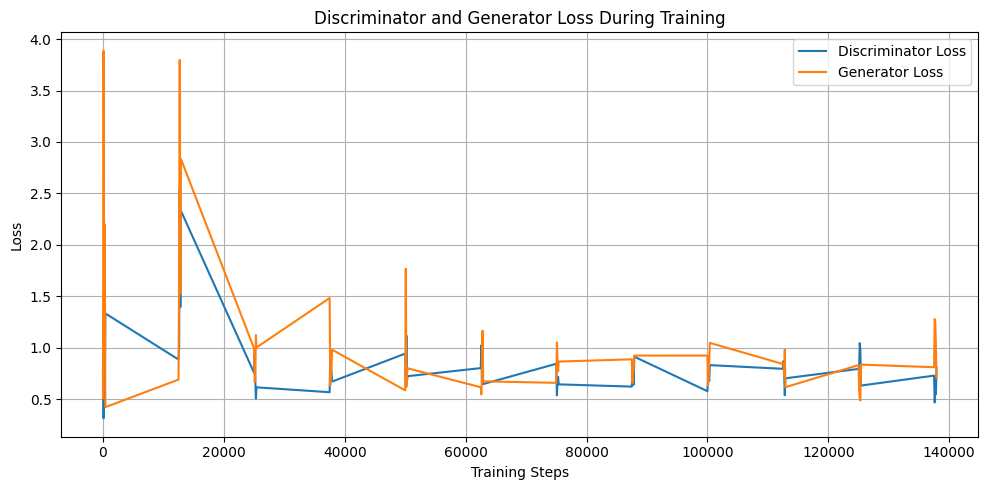

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(steps, losses_discriminator, label='Discriminator Loss')
plt.plot(steps, losses_generator, label='Generator Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Loss During Training')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
torch.save(generator.state_dict(), "generator_gan_br_ts_128.pth")
torch.save(discriminator.state_dict(), "discriminator_gan_br_ts_128.pth")

In [31]:
import random

# Pick N random examples from your validation set
n_samples = 4000
indices = random.sample(range(len(valid_dataset)), n_samples)

real_samples = []
real_conditions = []

for idx in indices:
    real_ts, condition = valid_dataset[idx]
    real_samples.append(real_ts)
    real_conditions.append(condition)

real_samples = torch.stack(real_samples)           # (n_samples, 252)
real_conditions = torch.stack(real_conditions)     # (n_samples, 3)

In [32]:
generator.eval()
with torch.no_grad():
    latent_dim = 100  # or whatever your latent size is
    z = torch.randn(n_samples, latent_dim)
    generated_samples = generator(z, real_conditions)  # (n_samples, 252)

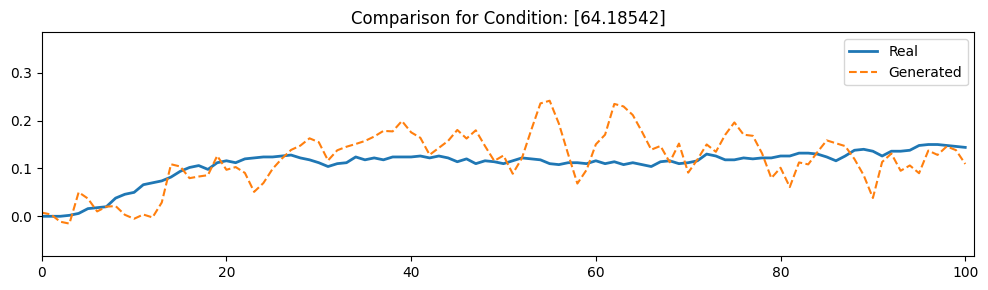

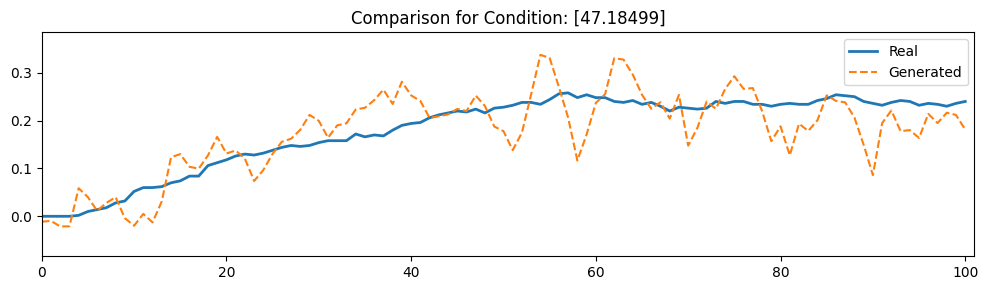

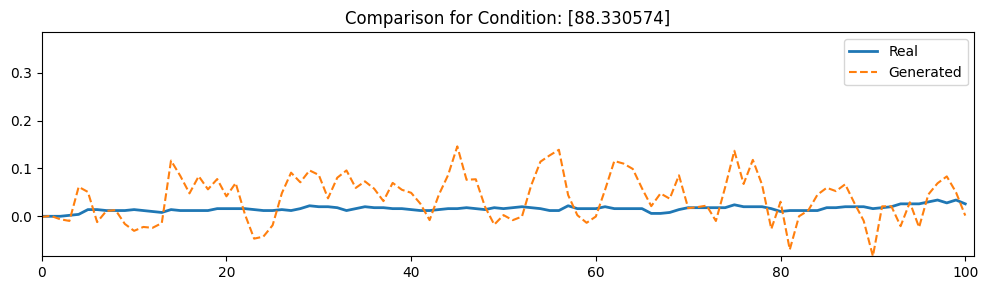

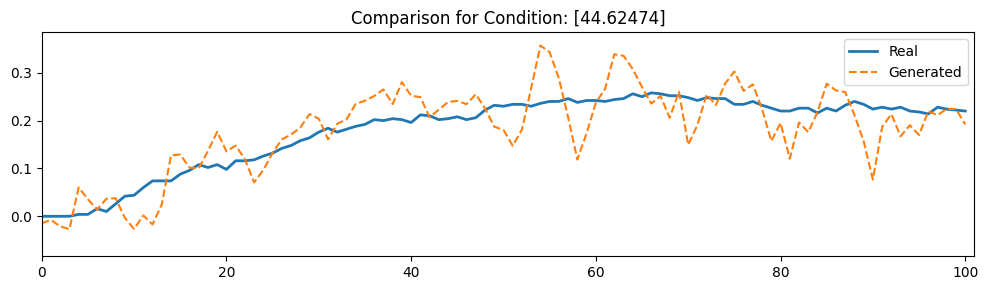

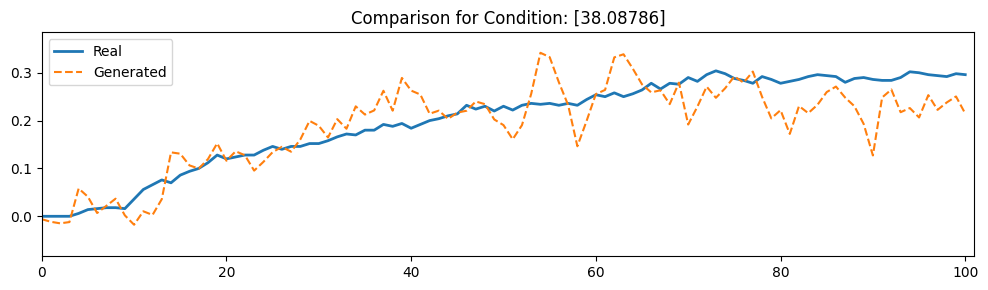

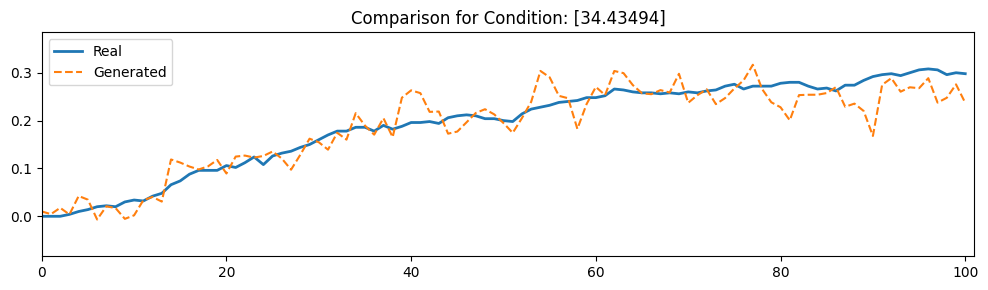

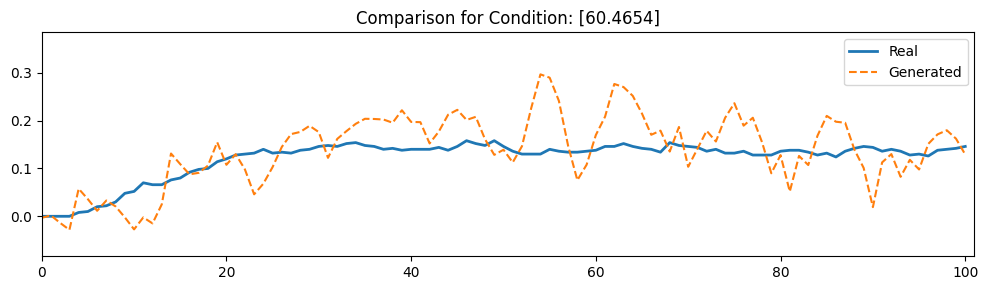

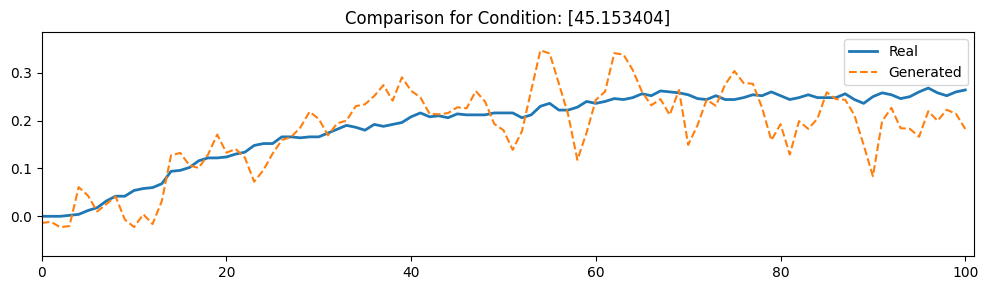

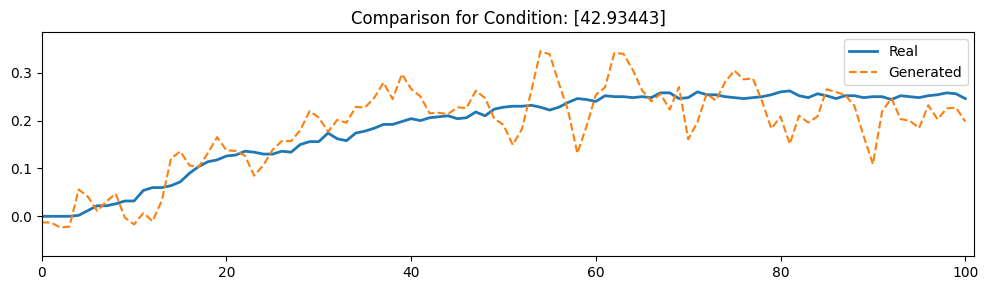

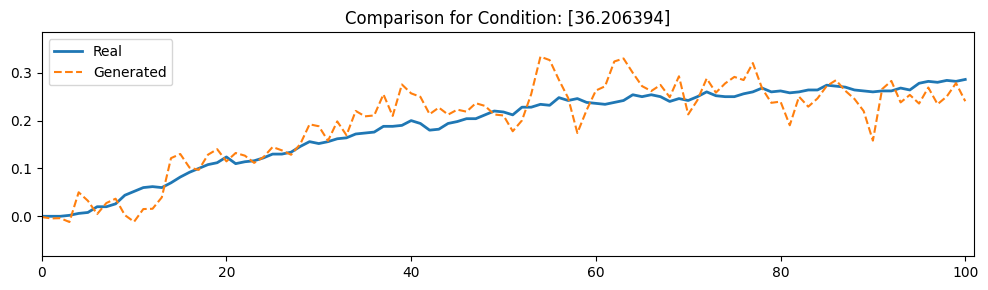

In [33]:
import matplotlib.pyplot as plt

# Calculate the global min and max for both real and generated samples
min_val = min(real_samples.min(), generated_samples.min())
max_val = max(real_samples.max(), generated_samples.max())

# Assuming real_samples, generated_samples, and real_conditions are already in the correct shape

for i in range(10):
    plt.figure(figsize=(10, 3))
    plt.plot(real_samples[i].cpu().numpy(), label="Real", linewidth=2)
    plt.plot(generated_samples[i].cpu().numpy(), label="Generated", linestyle="--")
    
    # Set the axis limits based on global min and max
    plt.xlim(0, len(real_samples[i]))  # Standardize x-axis (if you know your x range)
    plt.ylim(min_val, max_val)  # Standardize y-axis

    plt.title(f"Comparison for Condition: {real_conditions[i].cpu().numpy()}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [34]:
def evaluate_model_gan(real_samples, generated_samples):

    # convert list to numpy arrays
    predicted_values = generated_samples.cpu().numpy()  # [N, 255, 1]
    true_values = real_samples.cpu().numpy()            # [N, 255, 1]

    # flatten for metrics
    y_pred_flat = predicted_values.flatten()
    y_true_flat = true_values.flatten()
    
    # compute evaluation metrics
    mse = mean_squared_error(y_true_flat, y_pred_flat)
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    r2 = r2_score(y_true_flat, y_pred_flat)

    print(f"Validation MSE: {mse:.6f}")
    print(f"Validation MAE: {mae:.6f}")
    print(f"Validation R² Score: {r2:.6f}")

    return mse, mae, r2

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
evaluate_model_gan(real_samples, generated_samples)

Validation MSE: 0.001846
Validation MAE: 0.032592
Validation R² Score: 0.803114


(0.0018464012537151575, 0.0325918011367321, 0.8031142950057983)